In [1]:
!pip install bitarray

In [2]:
import cv2
from struct import pack
from bitarray import bitarray
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [3]:
def calculate_dct(a):
    def _calculate_dct(a):
        n = len(a)
        if n == 1:
            return list(a)
        else:
            half = n // 2
            alpha = [(a[i] + a[-(i + 1)]) for i in range(half)]
            beta = [(a[i] - a[-(i + 1)]) / (math.cos((i + 0.5) * math.pi / n) * 2.0) for i in range(half)]
            alpha = _calculate_dct(alpha)
            beta = _calculate_dct(beta)
            result = []
            for i in range(half - 1):
                result.append(alpha[i])
                result.append(beta[i] + beta[i + 1])
            result.append(alpha[-1])
            result.append(beta[-1])
            return result

    return _calculate_dct(a)

N = 8  # block size

def norm_coeff(n):
    if n == 0:
        return 1.0 / math.sqrt(2.0)
    else:
        return 1.0

def calculate_dct2(a):
    A = [[0 for _ in range(N)] for __ in range(N)]

    scaling = math.sqrt(2 / N)
    for col in range(N):
        cur = []
        for row in range(N):
            cur.append(a[row][col])
        cur = calculate_dct(cur)
        for row in range(N):
            A[row][col] = cur[row] * scaling
            if row == 0:
                A[row][col] /= math.sqrt(2)

    for row in range(N):
        cur = []
        for col in range(N):
            cur.append(A[row][col])
        cur = calculate_dct(cur)
        for col in range(N):
            A[row][col] = cur[col] * scaling
            if col == 0:
                A[row][col] /= math.sqrt(2)
    return A


In [4]:
def RGB_YCBCR(r, g, b):
    y = [[0.299 * r[i][j] + 0.587 * g[i][j] + 0.114 * b[i][j] for j in range(N)] for i in range(N)]
    cb = [[-0.169 * r[i][j] - 0.331 * g[i][j] + 0.5 * b[i][j] for j in range(N)] for i in range(N)]
    cr = [[0.5 * r[i][j] - 0.419 * g[i][j] - 0.081 * b[i][j] for j in range(N)] for i in range(N)]
    return y, cb, cr

In [5]:

def perform_quant(a, q):
    b = [[round(a[row][col] / q[row][col]) for col in range(N)] for row in range(N)]
    return b

In [6]:

def zz_order(b):
    ind = 0
    down = False
    z = [0 for _ in range(N * N)]
    for summation in range(2 * N - 1):
        row, col = None, None
        if down:
            row = 0
            col = summation - row
            if col >= N:
                col = N - 1
                row = summation - col
        else:
            col = 0
            row = summation - col
            if row >= N:
                row = N - 1
                col = summation - row

        while row >= 0 and row < N and col >= 0 and col < N:
            z[ind] = b[row][col]
            ind += 1
            if down:
                row += 1
                col -= 1
            else:
                row -= 1
                col += 1
        down = not down

    return z


In [7]:
def run_length_encoding(z):
    l, r = 1, 1
    lst = N * N - 1
    rle = []
    while lst >= 0 and z[lst] == 0:
        lst -= 1
    while r <= lst:
        if (z[r] == 0 and r - l + 1 == 16) or z[r] != 0:
            rle += [r - l, int(z[r]).bit_length(), z[r]]
            l = r + 1
        r += 1
    if lst != N * N - 1:
        rle += [0, 0]
    return rle

In [8]:
def huff_code(code_dict, node, code):
    if node[1][1] is None and node[1][2] is None:
        code_dict[node[1][0]] = code
        return

    if node[1][1] is not None:
        code_nxt = code + "0"
        huff_code(code_dict, node[1][1], code_nxt)

    if node[1][2] is not None:
        code_nxt = code + "1"
        huff_code(code_dict, node[1][2], code_nxt)

def huff_code_modify(code_dict):
    new_code_dict = dict()
    vals_list = [[] for _ in range(17)]
    for key, val in code_dict.items():
        vals_list[len(val)].append(key)

    cur = 0
    for i in range(17):
        for j in range(len(vals_list[i])):
            cur_bin = bin(cur)[2:]
            if '0' * (i - len(cur_bin)) + cur_bin == '1' * i:
                vals_list[i + 1] = [vals_list[i][j]] + vals_list[i + 1]
                continue
            new_code_dict[vals_list[i][j]] = '0' * (i - len(cur_bin)) + cur_bin
            cur += 1
        cur <<= 1
    return new_code_dict

def gen_huff_code(x):
    freq = dict()
    for i in range(len(x)):
        if x[i] in freq:
            freq[x[i]] += 1
        else:
            freq[x[i]] = 1

    pq = list()
    for ele in freq:
        pq.append([freq[ele], [ele, None, None]])

    pq.sort()
    while len(pq) > 1:
        t1 = pq[0]
        t2 = pq[1]

        curr = [t1[0] + t2[0], [-1, t1, t2]]
        pq.remove(t1)
        pq.remove(t2)
        pq.append(curr)
        pq.sort(key=lambda t: t[0])

    huffTree = pq[0]

    code_dict = dict()
    code = ""
    huff_code(code_dict, huffTree, code)
    code_dict = huff_code_modify(code_dict)
    return code_dict


In [9]:
def quant_table(jpeg_out, quant_table, type):
    jpeg_out.write(b'\xff\xdb')  # marker
    jpeg_out.write(pack(">H", 67))  # length of chunk
    jpeg_out.write(pack("B", type))
    zz_quant = zz_order(quant_table)
    for i in range(N * N):
        jpeg_out.write(pack("B", zz_quant[i]))

In [10]:
def write_SOF(jpeg_out, height, width, components):
    jpeg_out.write(b'\xff\xc0')  # marker
    jpeg_out.write(pack(">H", 8 + 3 * components))  # length of chunk
    jpeg_out.write(pack("B", 8))  # bits/sample
    jpeg_out.write(pack(">HHB", height, width, components))  # height,width,components of image

    for i in range(components):
        # id, sampling factor, quant table id
        jpeg_out.write(pack("BBB", i + 1, 16 + 1, min(i, 1)))

In [11]:
def huffman_table(jpeg_out, type, code):
    jpeg_out.write(b'\xff\xc4')  # marker
    jpeg_out.write(pack(">HB", 19 + len(code), type))

    val_list = [[] for _ in range(16)]
    for key, val in code.items():
        val_list[len(val) - 1].append(key)

    for i in range(16):
        jpeg_out.write(pack("B", len(val_list[i])))
    for i in range(16):
        for val in val_list[i]:
            jpeg_out.write(pack("B", val))

In [12]:
def modif_y(data):
    result = ""
    for i in range(0, len(data), 8):
        cur_byte = data[i:i + 8]
        result = result + cur_byte
        if cur_byte == "11111111":
            result = result + "00000000"
    return result

In [13]:
def write_SOS(jpeg_out, components, Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list, Y_dc_vli_list, CB_dc_vli_list, CR_dc_vli_list, Y_ac_vli_list, CB_ac_vli_list, CR_ac_vli_list, lum_dc_code, lum_ac_code, chr_dc_code, chr_ac_code):
    jpeg_out.write(b'\xff\xda')
    jpeg_out.write(pack(">HB", 6 + 2 * components, components))
    jpeg_out.write(b'\x01\x00\x02\x11\x03\x11')
    jpeg_out.write(pack("BBB", 0, 63, 0))
    Y_dc_ptr, CB_dc_ptr, CR_dc_ptr, Y_ac_ptr, CB_ac_ptr, CR_ac_ptr, Y_dc_vli_ptr, CB_dc_vli_ptr, CR_dc_vli_ptr, Y_ac_vli_ptr, CB_ac_vli_ptr, CR_ac_vli_ptr = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    data = ""
    while Y_dc_ptr < len(Y_dc_list):
        data = data + lum_dc_code[Y_dc_list[Y_dc_ptr]] + Y_dc_vli_list[Y_dc_vli_ptr]
        Y_dc_ptr += 1
        Y_dc_vli_ptr += 1
        length_block = 1
        while length_block < N * N and Y_ac_list[Y_ac_ptr] != 0:
            data = data + lum_ac_code[Y_ac_list[Y_ac_ptr]] + Y_ac_vli_list[Y_ac_vli_ptr]

            length_block += (Y_ac_list[Y_ac_ptr] >> 4)
            length_block += 1
            Y_ac_ptr += 1
            Y_ac_vli_ptr += 1
        if length_block < N * N:
            data = data + lum_ac_code[0]
            Y_ac_ptr += 1

        data = data + chr_dc_code[CB_dc_list[CB_dc_ptr]] + CB_dc_vli_list[CB_dc_vli_ptr]
        CB_dc_ptr += 1
        CB_dc_vli_ptr += 1
        length_block = 1
        while length_block < N * N and CB_ac_list[CB_ac_ptr] != 0:
            data = data + chr_ac_code[CB_ac_list[CB_ac_ptr]] + CB_ac_vli_list[CB_ac_vli_ptr]
            length_block += (CB_ac_list[CB_ac_ptr] >> 4)
            length_block += 1
            CB_ac_ptr += 1
            CB_ac_vli_ptr += 1
        if length_block < N * N:
            data = data + chr_ac_code[0]
            CB_ac_ptr += 1

        data = data + chr_dc_code[CR_dc_list[CR_dc_ptr]] + CR_dc_vli_list[CR_dc_vli_ptr]
        CR_dc_ptr += 1
        CR_dc_vli_ptr += 1
        length_block = 1
        while length_block < N * N and CR_ac_list[CR_ac_ptr] != 0:
            data = data + chr_ac_code[CR_ac_list[CR_ac_ptr]] + CR_ac_vli_list[CR_ac_vli_ptr]
            length_block += (CR_ac_list[CR_ac_ptr] >> 4)
            length_block += 1
            CR_ac_ptr += 1
            CR_ac_vli_ptr += 1
        if length_block < N * N:
            data = data + chr_ac_code[0]
            CR_ac_ptr += 1

    while len(data) % 8 != 0:
        data = data + "0"
    data = modif_y(data)
    data = bitarray(data)
    jpeg_out.write(data)


In [14]:
def variable_length_integer_representation(x):
    if x == 0:
        return ''
    if x < 0:
        x = -x
        ans = bin((~x) & ((1 << int(x).bit_length()) - 1))[2:]
        ans = "0" * (len(bin(x)) - 2 - len(ans)) + ans
    else:
        ans = bin(x)[2:]
    return ans

In [15]:
def run_length_encoding_to_binary(rle):
    rl_class, vli = [], []
    for i in range(0, len(rle), 3):
        rl_class.append(((rle[i] << 4) + rle[i + 1]))
        if rl_class[-1] == 0:
            break
        vli.append(variable_length_integer_representation(rle[i + 2]))
    return rl_class, vli

In [16]:

def resize_and_fill(r, g, b):
    new_height, new_width = ((len(r) + 7) // 8) * 8, ((len(r[0]) + 7) // 8) * 8
    new_r = [[r[min(i, len(r) - 1)][min(j, len(r[0]) - 1)] for j in range(new_width)] for i in range(new_height)]
    new_g = [[g[min(i, len(g) - 1)][min(j, len(g[0]) - 1)] for j in range(new_width)] for i in range(new_height)]
    new_b = [[b[min(i, len(b) - 1)][min(j, len(b[0]) - 1)] for j in range(new_width)] for i in range(new_height)]

    return new_r, new_g, new_b


In [17]:
def compress_image(r,g,b,output_file):
    height,width = len(r), len(r[0])
    r,g,b = resize_and_fill(r,g,b)
    Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list = [],[],[],[],[],[] # to get distribution for huffman
    Y_dc_vli_list,CB_dc_vli_list,CR_dc_vli_list,Y_ac_vli_list,CB_ac_vli_list,CR_ac_vli_list = [],[],[],[],[],[]
    quant_lum = [[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]
    quant_chr = [[17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]]

    scale = float(input("Enter the scaling on standard quant matrix:"))
    quant_lum = [[min(max(1,int(quant_lum[i][j]*scale)),255) for j in range(N)] for i in range(N)]
    quant_chr = [[min(max(1,int(quant_chr[i][j]*scale)),255) for j in range(N)] for i in range(N)]

    prev_Y_dc,prev_CB_dc,prev_CR_dc = 0,0,0
    for i in range(len(r)//8):
        for j in range(len(r[0])//8):
            cur_r = [[r[x][y]-128 for y in range(j*8,j*8+8)] for x in range(i*8,i*8+8)]
            cur_g = [[g[x][y]-128 for y in range(j*8,j*8+8)] for x in range(i*8,i*8+8)]
            cur_b = [[b[x][y]-128 for y in range(j*8,j*8+8)] for x in range(i*8,i*8+8)]

            y,cb,cr = RGB_YCBCR(cur_r,cur_g,cur_b)
            Y,CB,CR = calculate_dct2(y),calculate_dct2(cb),calculate_dct2(cr)

            Y,CB,CR = perform_quant(Y,quant_lum),perform_quant(CB,quant_chr),perform_quant(CR,quant_chr)
            Y_z,CB_z,CR_z = zz_order(Y),zz_order(CB),zz_order(CR)

            Y_rle,CB_rle,CR_rle = run_length_encoding(Y_z),run_length_encoding(CB_z),run_length_encoding(CR_z)
            Y_rl_class, Y_vli = run_length_encoding_to_binary(Y_rle)
            CB_rl_class, CB_vli = run_length_encoding_to_binary(CB_rle)
            CR_rl_class, CR_vli = run_length_encoding_to_binary(CR_rle)

            Y_ac_list = Y_ac_list+Y_rl_class
            CB_ac_list = CB_ac_list+CB_rl_class
            CR_ac_list = CR_ac_list+CR_rl_class

            Y_ac_vli_list = Y_ac_vli_list+Y_vli
            CB_ac_vli_list = CB_ac_vli_list+CB_vli
            CR_ac_vli_list = CR_ac_vli_list+CR_vli

            Y_dc,CB_dc,CR_dc = Y_z[0]-prev_Y_dc, CB_z[0]-prev_CB_dc, CR_z[0]-prev_CR_dc
            Y_dc_list.append(int(Y_dc).bit_length())
            CB_dc_list.append(int(CB_dc).bit_length())
            CR_dc_list.append(int(CR_dc).bit_length())

            Y_dc_vli_list.append(variable_length_integer_representation(Y_dc))
            CB_dc_vli_list.append(variable_length_integer_representation(CB_dc))
            CR_dc_vli_list.append(variable_length_integer_representation(CR_dc))

            prev_Y_dc,prev_CB_dc,prev_CR_dc = Y_z[0],CB_z[0],CR_z[0]

    lum_dc_code = gen_huff_code(Y_dc_list)
    lum_ac_code = gen_huff_code(Y_ac_list)
    chr_dc_code = gen_huff_code(CB_dc_list+CR_dc_list)
    chr_ac_code = gen_huff_code(CB_ac_list+CR_ac_list)


    jpeg_out = open(output_file+".jpg", "wb")
    jpeg_out.write(b'\xff\xd8\xff\xe0')
    jpeg_out.write(pack(">H",16))
    jpeg_out.write(b'JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00')


    quant_table(jpeg_out, quant_lum, 0)
    quant_table(jpeg_out, quant_chr, 1)

    write_SOF(jpeg_out,height,width,3)

    huffman_table(jpeg_out,0,lum_dc_code)
    huffman_table(jpeg_out,16,lum_ac_code)
    huffman_table(jpeg_out,1,chr_dc_code)
    huffman_table(jpeg_out,17,chr_ac_code)

    write_SOS(jpeg_out,3,Y_dc_list, CB_dc_list, CR_dc_list, Y_ac_list, CB_ac_list, CR_ac_list,Y_dc_vli_list, CB_dc_vli_list, CR_dc_vli_list, Y_ac_vli_list, CB_ac_vli_list, CR_ac_vli_list,lum_dc_code,lum_ac_code,chr_dc_code,chr_ac_code)

    jpeg_out.write(b'\xff\xd9')
    jpeg_out.close()
    return cv2.imread(output_file + ".jpg")


In [18]:
# Display images after saving the output
def display_images(input_img, output_img, input_file, output_file):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    if len(input_img.shape) == 3:
        plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
        plt.title('Input Image\nDimensions: {} x {}\nFilesize: {} bytes'.format(
            input_img.shape[1], input_img.shape[0], os.path.getsize(input_file)))
    else:
        plt.imshow(input_img, cmap='gray', vmin=0, vmax=255)
        plt.title('Input Image (Grayscale)\nDimensions: {} x {}\nFilesize: {} bytes'.format(
            input_img.shape[1], input_img.shape[0], os.path.getsize(input_file)))

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title('Output Image\nDimensions: {} x {}\nFilesize: {} bytes'.format(
        output_img.shape[1], output_img.shape[0], os.path.getsize(output_file + ".jpg")))

    plt.show()

Enter raw image file name: /content/lena_colored_256.bmp
Enter output file name: 5
Enter the scaling on standard quant matrix:5


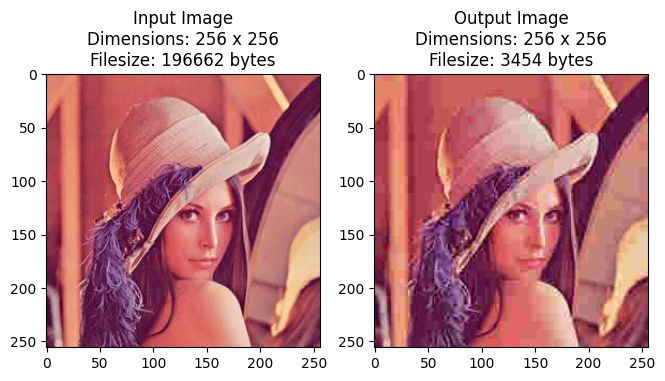

In [20]:

file = input("Enter raw image file name: ")
img = cv2.imread(file)
r = img[:, :, 2]
r = [[r[i][j] for j in range(len(r[0]))] for i in range(len(r))]
g = img[:, :, 1]
g = [[g[i][j] for j in range(len(g[0]))] for i in range(len(g))]
b = img[:, :, 0]
b = [[b[i][j] for j in range(len(b[0]))] for i in range(len(b))]

output_file = input("Enter output file name: ")
compress_img = compress_image(r, g, b,output_file)  # Assign the output file name

display_images(img, compress_img, file, output_file)